In [175]:
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

%matplotlib inline

In [176]:
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [177]:
"""Sequence are a safer way to do multiprocessing. This structure guarantees that the 
network will only train once on each sample per epoch which is not the case with generators"""

class ProcessData(keras.utils.Sequence):
    """
    Args:
        ids: It can be train or test ids
        **path: It can be train or test path**
        batch_size: No. of images in the batch
        img_size: Size of image we need to reshape into
    """
    
    def __init__(self, ids, path, batch_size=8, img_size=128 ):   #constructor
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.img_size = img_size
        
    #To load corresponding image and mask using id    
    def __load__(self, id_name):
        
        img_path = os.path.join(self.path, id_name, 'images' , id_name + ".png")#1 image path
        mask_path = os.path.join(self.path, id_name, 'masks/') #mask folder path
        all_masks = os.listdir(mask_path) #list of masks in folder
        
        
        img = cv2.imread(img_path, 1) #reads in rgb format
        image = cv2.resize(img, (self.img_size, self.img_size)) #resize image
        
        mask = np.zeros((self.img_size, self.img_size, 1))

        for mask_file in all_masks:
            
            mask_img_path = mask_path + mask_file #1 mask path
            mask_img = cv2.imread(mask_img_path, -1)    #reads in gray-scale format
            mask1 = resize(mask_img, (self.img_size, self.img_size)) #(128,128) but we need 2 add 1 more size
            mask1_exp = np.expand_dims(mask1, axis=-1)  #(128,128,1)

            mask = np.maximum(mask, mask1_exp) #mask is updated
            
        img = image/255
        mask = mask/255
        
        return img, mask
    
    def __getitem__(self, index):

        #
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        #Batch of files (based on batch_size)
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        #Getting images and masks from batch of files
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

# Hyperparameters

In [178]:
img_size = 128
train_path = '/home/sumanthmeenan/Desktop/projects/U-Net/data/train/'
batch_size = 8
epochs = 5

train_data_ids = os.listdir(train_path) 
 
validation_data_size = 10

valid_ids = train_data_ids[:validation_data_size]
train_ids = train_data_ids[validation_data_size:]

# Getting X and Y

In [179]:
gen = ProcessData(train_ids, train_path, batch_size=batch_size, img_size=img_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

(8, 128, 128, 3) (8, 128, 128, 1)


# Display Image and Mask

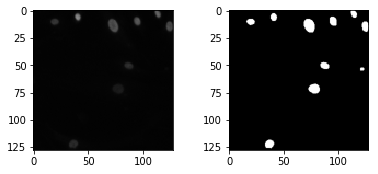

In [180]:
#we have 8 examples in x, select random number(b/w 0 to 8) and view that image and mask
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (img_size, img_size)), cmap="gray")

# Different Convolutional Blocks

In [181]:

def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

# UNet Model

In [182]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((img_size, img_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [183]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 128, 128, 16) 448         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 128, 128, 16) 2320        conv2d_57[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 64, 64, 16)   0           conv2d_58[0][0]                  
____________________________________________________________________________________________

# Training the model

In [184]:
train_gen = ProcessData(train_ids, train_path, img_size=img_size, batch_size=batch_size)
valid_gen = ProcessData(valid_ids, train_path, img_size=img_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs)

Epoch 1/5
2/2 [==============================] - 8s 4s/step - loss: 0.6737 - accuracy: 0.8045 - val_loss: 0.6439 - val_accuracy: 0.8043
Epoch 2/5
2/2 [==============================] - 4s 2s/step - loss: 0.4776 - accuracy: 0.7697 - val_loss: 0.0312 - val_accuracy: 0.7887
Epoch 3/5
2/2 [==============================] - 4s 2s/step - loss: 0.0438 - accuracy: 0.8628 - val_loss: 0.1271 - val_accuracy: 0.7887
Epoch 4/5
2/2 [==============================] - 4s 2s/step - loss: 0.1546 - accuracy: 0.8628 - val_loss: 0.0510 - val_accuracy: 0.7887
Epoch 5/5
2/2 [==============================] - 4s 2s/step - loss: 0.0799 - accuracy: 0.7118 - val_loss: 0.0211 - val_accuracy: 0.7887


In [185]:
model.save_weights("UNetW.h5")

## Dataset for prediction
x, y = valid_gen.__getitem__(1)
result = model.predict(x)

result = (result > 0.5).astype(np.uint8)

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (img_size, img_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (img_size, img_size)), cmap="gray")